In [1]:
import pandas as pd
#import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import plotly.express as px
import plotly.io as pio
import seaborn as sns
from string import printable
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [2]:
df= pd.read_csv('/Users/carlosruiz/Desktop/Animal-Shelter-Project/Data/aac_intakes_outcomes.csv')

In [3]:
df

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,dob_year,dob_month,dob_monthyear,age_upon_intake,animal_id_intake,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,count,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.000000,"(7.5, 10.0]",2017-12-07 14:07:00,12,2017,2017-12,Thursday,0,1.0,2007,7,2017-12,10 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,Colony Creek And Hunters Trace in Austin (TX),Normal,Stray,Neutered Male,1,3650,10.000000,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.000000,"(5.0, 7.5]",2014-12-20 16:35:00,12,2014,2014-12,Saturday,16,2.0,2007,7,2014-12,7 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,8700 Research Blvd in Austin (TX),Normal,Public Assist,Neutered Male,1,2555,7.000000,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.000000,"(5.0, 7.5]",2014-03-08 17:10:00,3,2014,2014-03,Saturday,17,3.0,2007,7,2014-03,6 years,A006100,Dog,Spinone Italiano Mix,Yellow/White,8700 Research in Austin (TX),Normal,Public Assist,Neutered Male,1,2190,6.000000,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.000000,"(7.5, 10.0]",2014-04-07 15:12:00,4,2014,2014-04,Monday,15,1.0,2004,4,2014-04,10 years,A047759,Dog,Dachshund,Tricolor,Austin (TX),Normal,Owner Surrender,Neutered Male,1,3650,10.000000,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.000000,"(15.0, 17.5]",2013-11-16 11:54:00,11,2013,2013-11,Saturday,11,1.0,1997,10,2013-11,16 years,A134067,Dog,Shetland Sheepdog,Brown/White,12034 Research Blvd in Austin (TX),Injured,Public Assist,Neutered Male,1,5840,16.000000,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79667,2 weeks,A769060,2018-03-14 00:00:00,Partner,Transfer,Unknown,14,0.038356,"(-0.025, 2.5]",2018-03-29 18:14:00,3,2018,2018-03,Thursday,18,1.0,2018,3,2018-03,2 weeks,A769060,Cat,Domestic Shorthair Mix,Tortie,1208 Coaches Crossing in Pflugerville (TX),Normal,Stray,Unknown,1,14,0.038356,"(-0.025, 2.5]",2018-03-29 16:23:00,3,2018,2018-03,Thursday,16,1.0,0 days 01:51:00.000000000,0.077083
79668,2 years,A769064,2016-03-29 00:00:00,Rabies Risk,Euthanasia,Unknown,730,2.000000,"(-0.025, 2.5]",2018-03-29 18:30:00,3,2018,2018-03,Thursday,18,1.0,2016,3,2018-03,2 years,A769064,Other,Bat Mix,Brown,2519 Scarbrough Dr in Travis (TX),Normal,Wildlife,Unknown,1,730,2.000000,"(-0.025, 2.5]",2018-03-29 17:13:00,3,2018,2018-03,Thursday,17,1.0,0 days 01:17:00.000000000,0.053472
79669,1 year,A769065,2017-03-29 00:00:00,Rabies Risk,Euthanasia,Unknown,365,1.000000,"(-0.025, 2.5]",2018-03-29 18:28:00,3,2018,2018-03,Thursday,18,1.0,2017,3,2018-03,1 year,A769065,Other,Bat Mix,Brown,1122 Walton Ln in Austin (TX),Normal,Wildlife,Unknown,1,365,1.000000,"(-0.025, 2.5]",2018-03-29 17:19:00,3,2018,2018-03,Thursday,17,1.0,0 days 01:09:00.000000000,0.047917
79670,10 months,A769066,2017-05-01 00:00:00,NaN,Retu

In [4]:
df.drop(['count','dob_monthyear'],axis=1,inplace=True)

In [5]:
df=df[(df['animal_type']== 'Dog')]
df=df[df.outcome_type=='Adoption']

In [6]:
df.date_of_birth=df.date_of_birth.apply(lambda x: x[:10])

In [7]:
df['outcome_datetime']=pd.to_datetime(df['outcome_datetime'])
df['intake_datetime']=pd.to_datetime(df['intake_datetime'])

In [8]:
df['time_in_shelter'] = df['outcome_datetime'] - df['intake_datetime']

In [9]:
df['outcome_month']=df.outcome_datetime.apply(lambda x: str(x)[5:7])
df['outcome_year']=df.outcome_datetime.apply(lambda x: str(x)[:4])
df['outcome_weekday']=df.outcome_datetime.dt.dayofweek

In [10]:
df['outcome_weekday']=df.outcome_datetime.dt.dayofweek

In [11]:
df['intake_month']=df.intake_datetime.apply(lambda x: str(x)[5:7])
df['intake_year']=df.intake_datetime.apply(lambda x: str(x)[:4])
df['intake_weekday']=df.intake_datetime.dt.dayofweek

In [12]:
condition=[
    df['intake_condition'] == 'Aged',
    df['intake_condition'] == 'Ferral',
    df['intake_condition'] == 'Injured',
    df['intake_condition'] == 'Normal',
    df['intake_condition'] == 'Nursing',
    df['intake_condition'] == 'Other',
    df['intake_condition'] == 'Pregnant',
    df['intake_condition'] == 'Sick'
]
choises=[
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    0
]
df['health']=np.select(condition,choises)

In [13]:
def unique_breed_dic (dictionary,column):
    df=dictionary.copy()
    df.reset_index(drop=True,inplace=True)
    
    list_of_breeds=[]
    for i in range(len(df[column])):
        if df[column][i].find('/')==-1:
            list_of_breeds.append([df[column][i]])
        else:
            list_of_breeds.append(df[column][i].split('/'))
        
    list_of_breeds=[val for sublist in list_of_breeds for val in sublist]
    
    dup_list=[]
    uniqe_list=[]


    for i in list_of_breeds:
        dup_list.append(i)
    unique_list=list(set(dup_list))


    for i in list_of_breeds:
        dup_list.append(i)
    unique_list=list(set(dup_list))
    final_dic={}
    for company in unique_list:
        final_dic[company]=0

    for company in dup_list:
        final_dic[company]=final_dic[company]+1
    return final_dic

In [14]:
unique_breed_dic(df[df.animal_type=='Cat'],'breed')

{}

In [15]:
conditions=[
    (df.intake_type=='Owner Surrender')|(df.intake_type=='Euthanasia Request')
]
choises=[
    1
]

df['was_owned']=np.select(conditions,choises,default=0)

In [16]:
%%time
def season_of_date(date):
    year = str(date.year)
    seasons = {'Spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'Summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'Fall': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date.date() in seasons['Spring']:
        return 1
    if date.date() in seasons['Summer']:
        return 2
    if date.date() in seasons['Fall']:
        return 3
    else:
        return 4
df['season'] = df.intake_datetime.map(season_of_date)

CPU times: user 23.8 s, sys: 493 ms, total: 24.3 s
Wall time: 23.9 s


In [17]:
df=pd.get_dummies(df, columns=['intake_month'])

In [18]:
df

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_number,dob_year,dob_month,age_upon_intake,animal_id_intake,animal_type,breed,color,found_location,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,health,was_owned,season,intake_month_01,intake_month_02,intake_month_03,intake_month_04,intake_month_05,intake_month_06,intake_month_07,intake_month_08,intake_month_09,intake_month_10,intake_month_11,intake_month_12
12,16 years,A200922,1997-10-03,Foster,Adoption,Neutered Male,5840,16.000000,"(15.0, 17.5]",2013-11-22 09:44:00,11,2013,2013-11,4,9,1.0,1997,10,16 years,A200922,Dog,Dachshund Mix,Black/Tan,Austin (TX),Normal,Owner Surrender,Neutered Male,5840,16.000000,"(15.0, 17.5]",2013-10-03 15:47:00,2013,2013-10,3,15,1.0,49 days 17:57:00,49.747917,1,1,3,0,0,0,0,0,0,0,0,0,1,0,0
14,17 years,A210457,1999-06-01,Foster,Adoption,Neutered Male,6205,17.000000,"(15.0, 17.5]",2016-10-07 12:34:00,10,2016,2016-10,4,12,1.0,1999,6,17 years,A210457,Dog,Chihuahua Shorthair,Tan/Black,4424 S Mopac #412 in Austin (TX),Aged,Public Assist,Neutered Male,6205,17.000000,"(15.0, 17.5]",2016-09-28 12:05:00,2016,2016-09,2,12,1.0,9 days 00:29:00,9.020139,1,0,3,0,0,0,0,0,0,0,0,1,0,0,0
22,15 years,A226069,2000-06-17,Foster,Adoption,Neutered Male,5475,15.000000,"(12.5, 15.0]",2015-10-29 15:00:00,10,2015,2015-10,3,15,1.0,2000,6,15 years,A226069,Dog,Labrador Retriever/Beagle,Sable/White,Wheless Ln And Berkman Dr in Austin (TX),Normal,Stray,Neutered Male,5475,15.000000,"(12.5, 15.0]",2015-10-06 12:29:00,2015,2015-10,1,12,1.0,23 days 02:31:00,23.104861,1,0,3,0,0,0,0,0,0,0,0,0,1,0,0
32,15 years,A249087,2001-01-02,Foster,Adoption,Spayed Female,5475,15.000000,"(12.5, 15.0]",2016-11-15 10:37:00,11,2016,2016-11,1,10,1.0,2001,1,15 years,A249087,Dog,German Shepherd Mix,Black/Brown,E 6Th St And Pedernales in Austin (TX),Normal,Stray,Spayed Female,5475,15.000000,"(12.5, 15.0]",2016-08-17 14:05:00,2016,2016-08,2,14,1.0,89 days 20:32:00,89.855556,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0
48,11 years,A274546,2002-05-25,NaN,Adoption,Spayed Female,4015,11.000000,"(10.0, 12.5]",2013-11-16 12:24:00,11,2013,2013-11,5,12,1.0,2002,5,11 years,A274546,Dog,Pointer Mix,Tricolor,Manchaca And Slaughter in Austin (TX),Normal,Stray,Spayed Female,4015,11.000000,"(10.0, 12.5]",2013-11-13 18:16:00,2013,2013-11,2,18,1.0,2 days 18:08:00,2.755556,1,0,3,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79647,7 years,A769012,2011-03-29,NaN,Adoption,Spayed Female,2555,7.000000,"(5.0, 7.5]",2018-04-01 12:36:00,04,2018,2018-04,6,12,1.0,2011,3,7 years,A769012,Dog,Chihuahua Shorthair Mix,Tan,Springdale And Govalle in Austin (TX),Normal,Stray,Spayed Female,2555,7.000000,"(5.0, 7.5]",2018-03-28 17:48:00,2018,2018-03,2,17,1.0,3 days 18:48:00,3.783333,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
79649,2 months,A769014,2018-01-28,NaN,Adoption,Neutered Male,60,0.164384,"(-0.025, 2.5]",2018-04-02 19:05:00,04,2018,2018-04,0,19,1.0,2018,1,1 month,A769014,Dog,Pit Bull Mix,Black/White,1044 Norwood Park Boulevard in Austin (TX),Normal,Stray,Intact Male,30,0.082192,"(-0.025, 2.5]",2018-03-28 18:08:00,2018,2018-03,2,18,1.0,5 days 00:57:00,5.039583,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
79653,2 months,A769020,2018-01-18,NaN,Adoption,Neutered Male,60,0.164384,"(-0.025, 2.5]",2018-04-01 17:27:00,04,2018,2018-04,6,17,1.0,2018,1,2 months,A769020,Dog,German Shepherd,Black/Tan,Austin (TX),Normal,Stray,Intact Male,60,0.164384,"(-0.025, 2.5]",2018-03-28 18:51:00,2018,2018-03,

In [76]:
data=df.intake_weekday.value_counts()
fig=px.bar(data, title="Amount of intakes per Weekday",labels={'index': 'Months','value':'Amounts'},color_discrete_sequence=['#FF847C'])
fig.update_layout(
    xaxis_tickfont_size=14,
    xaxis_tickmode='array',
    xaxis_tickvals=[0,1,2,3,4,5,6],
    xaxis_ticktext=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
    showlegend=False,
    plot_bgcolor = '#6C5B7B',
    )

fig.show()

In [20]:
data=df.outcome_weekday.value_counts()
fig=px.bar(data, title="Amount of adoptions per Weekday",labels={'index': 'Months','value':'Amounts'},color_discrete_sequence=['lightblue'])
fig.update_layout(
    xaxis_tickfont_size=14,
    xaxis_tickmode='array',
    xaxis_tickvals=[0,1,2,3,4,5,6],
    xaxis_ticktext=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],
    showlegend=False,
    plot_bgcolor = '#6C5B7B'
    )

fig.show()

In [78]:
data=df.season.value_counts()
fig=px.bar(data, title="Amount of intakes per Season",labels={'index': 'Months','value':'Amounts'},color_discrete_sequence=['#b9A9a9'])
fig.update_layout(
    showlegend=False,
    plot_bgcolor = '#F9CDAD',
    xaxis_tickvals=[1,2,3,4],
    xaxis_ticktext=['Spring',"Summer",'Fall','Winter'],
    )

fig.show()

In [22]:
df.columns

Index(['age_upon_outcome', 'animal_id_outcome', 'date_of_birth',
       'outcome_subtype', 'outcome_type', 'sex_upon_outcome',
       'age_upon_outcome_(days)', 'age_upon_outcome_(years)',
       'age_upon_outcome_age_group', 'outcome_datetime', 'outcome_month',
       'outcome_year', 'outcome_monthyear', 'outcome_weekday', 'outcome_hour',
       'outcome_number', 'dob_year', 'dob_month', 'age_upon_intake',
       'animal_id_intake', 'animal_type', 'breed', 'color', 'found_location',
       'intake_condition', 'intake_type', 'sex_upon_intake',
       'age_upon_intake_(days)', 'age_upon_intake_(years)',
       'age_upon_intake_age_group', 'intake_datetime', 'intake_year',
       'intake_monthyear', 'intake_weekday', 'intake_hour', 'intake_number',
       'time_in_shelter', 'time_in_shelter_days', 'health', 'was_owned',
       'season', 'intake_month_01', 'intake_month_02', 'intake_month_03',
       'intake_month_04', 'intake_month_05', 'intake_month_06',
       'intake_month_07', 'intak

In [23]:
features=[ 'age_upon_intake', 'breed', 'color', 'found_location',
       'intake_condition', 'intake_type', 'sex_upon_intake',
       'age_upon_intake_(days)', 'age_upon_intake_(years)',
       'age_upon_intake_age_group', 'intake_datetime', 'intake_year',
       'intake_monthyear', 'intake_weekday', 'intake_hour', 'intake_number', 'health', 'was_owned',
       'season', 'intake_month_01', 'intake_month_02', 'intake_month_03',
       'intake_month_04', 'intake_month_05', 'intake_month_06',
       'intake_month_07', 'intake_month_08', 'intake_month_09',
       'intake_month_10', 'intake_month_11', 'intake_month_12']

In [24]:
df[features].dtypes

age_upon_intake                      object
breed                                object
color                                object
found_location                       object
intake_condition                     object
intake_type                          object
sex_upon_intake                      object
age_upon_intake_(days)                int64
age_upon_intake_(years)             float64
age_upon_intake_age_group            object
intake_datetime              datetime64[ns]
intake_year                          object
intake_monthyear                     object
intake_weekday                        int64
intake_hour                           int64
intake_number                       float64
health                                int64
was_owned                             int64
season                                int64
intake_month_01                       uint8
intake_month_02                       uint8
intake_month_03                       uint8
intake_month_04                 

In [25]:
df[['time_in_shelter','time_in_shelter_days']]

,time_in_shelter,time_in_shelter_days
12,49 days 17:57:00,49.747917
14,9 days 00:29:00,9.020139
22,23 days 02:31:00,23.104861
32,89 days 20:32:00,89.855556
48,2 days 18:08:00,2.755556
...,...,...
79647,3 days 18:48:00,3.783333
79649,5 days 00:57:00,5.039583
79653,3 days 22:36:00,3.941667
79654,5 days 03:39:00,5.152083


In [26]:
df[features].corr()

,age_upon_intake_(days),age_upon_intake_(years),intake_weekday,intake_hour,intake_number,health,was_owned,season,intake_month_01,intake_month_02,intake_month_03,intake_month_04,intake_month_05,intake_month_06,intake_month_07,intake_month_08,intake_month_09,intake_month_10,intake_month_11,intake_month_12
age_upon_intake_(days),1.000000,1.000000,0.010650,-0.012498,0.016435,-0.018021,0.153380,0.009559,0.005403,0.007847,-0.008750,-0.000007,-0.000079,0.002020,-0.009580,-0.000493,0.008560,-0.005066,0.005263,-0.005121
age_upon_intake_(years),1.000000,1.000000,0.010650,-0.012498,0.016435,-0.018021,0.153380,0.009559,0.005403,0.007847,-0.008750,-0.000007,-0.000079,0.002020,-0.009580,-0.000493,0.008560,-0.005066,0.005263,-0.005121
intake_weekday,0.010650,0.010650,1.000000,-0.045480,-0.007115,0.011312,0.009056,0.012615,0.025165,0.000131,-0.006347,0.006767,-0.013084,-0.004838,0.022594,-0.003620,-0.010056,-0.006468,0.006248,-0.016475
intake_hour,-0.012498,-0.012498,-0.045480,1.000000,-0.003560,0.059818,-0.038636,0.025312,0.009172,0.002492,0.008196,0.004498,-0.014094,-0.000906,-0.040006,-0.016961,-0.015016,0.012962,0.019791,0.024668
intake_number,0.016435,0.016435,-0.007115,-0.003560,1.000000,0.023459,0.036722,-0.002373,-0.009189,0.007242,-0.003551,0.007694,-0.001427,0.003055,-0.002187,0.007226,0.010520,-0.001954,0.000854,-0.015856
health,-0.018021,-0.018021,0.011312,0.059818,0.023459,1.000000,0.045681,0.019174,0.015552,0.017123,0.003181,-0.000243,-0.004645,-0.018758,-0.000603,0.003495,-0.007281,-0.006172,0.002044,-0.005758
was_owned,0.153380,0.153380,0.009056,-0.038636,0.036722,0.045681,1.000000,0.022047,0.004140,0.045754,0.005073,0.013845,-0.013154,-0.014633,-0.026590,-0.002829,0.010214,-0.015763,-0.024924,0.015889
season,0.009559,0.009559,0.012615,0.025312,-0.002373,0.019174,0.022047,1.000000,0.415367,0.404643,0.112392,-0.384696,-0.413846,-0.324037,-0.144185,-0.147225,-0.076098,0.119477,0.114049,0.212482
intake_month_01,0.005403,0.005403,0.025165,0.009172,-0.009189,0.015552,0.004140,0.415367,1.000000,-0.104161,-0.101723,-0.090355,-0.097202,-0.097676,-0.093416,-0.095386,-0.091813,-0.102060,-0.097424,-0.103919
intake_month_02,0.007847,0.007847,0.000131,0.002492,0.007242,0.017123,0.045754,0.404643,-0.104161,1.000000,-0.099096,-0.088023,-0.094692,-0.095154,-0.091004,-0.092923,-0.089442,-0.099425,-0.094908,-0.101236


In [27]:
# n = 4
# row_groups= [features[i:i+n] for i in range(0, len(features), n) ]

In [28]:
# for i in row_groups:
#     pp = sns.pairplot(data=df, y_vars=['time_in_shelter_days'],x_vars=i, kind="reg", height=3)

In [29]:
# %%time
# lr_model = ols(formula='time_in_shelter_days~intake_datetime+intake_year+intake_monthyear+intake_weekday+intake_hour+intake_number+health+was_owned+season+intake_month_01+intake_month_02+intake_month_03+intake_month_04+intake_month_05+intake_month_06+intake_month_07+intake_month_08+intake_month_09+intake_month_10+intake_month_11+intake_month_12', data=df).fit()

# lr_model.summary()

In [30]:
#  'age_upon_intake+breed+color+found_location+intake_condition+intake_type+sex_upon_intake+age_upon_intake_(days)+age_upon_intake_(years)+age_upon_intake_age_group+intake_datetime+intake_year+intake_monthyear+intake_weekday+intake_hour+intake_number+health+was_owned+season+intake_month_01+intake_month_02+intake_month_03+intake_month_04+intake_month_05+intake_month_06+intake_month_07+intake_month_08+intake_month_09+intake_month_10+intake_month_11+intake_month_12'

In [31]:
df2=df.copy()
df2['time_in_shelter']=df2.time_in_shelter.apply(lambda x: int(str(x)[:2]))
df2['intake_datetime']=df2.intake_datetime.apply(lambda x: str(str(x)[:10]))
df2['age_upon_intake']=df2.age_upon_intake.apply(lambda x: int(x[:2]))
df2['age_upon_intake_age_group']=df2.age_upon_intake_age_group.apply(lambda x: list(map(float,x.strip('(]').split(','))))
df2['color']=df2.color.apply(lambda x: x.strip('/').split('/'))
df2.reset_index(drop=True,inplace=True)

In [54]:
brown=['Brown Brindle','Red','Liver','Brown','Tan','Ruddy','Chocolate','Brown Tiger','Sable']
spotted=["Yellow Brindle",'Blue Merle','Black Tiger','Red Merle', 'Liver Tick','Agouti','Blue Tick','Black Brindle','Fawn','Brown Merle','Red Tick']
mustard=['Buff','Orange','Apricot']
other=['Tricolor','Pink','Blue']
white=['Silver','Cream','White']
black=['Black','Black Smoke','Gray','Blue Tiger']
gold=['Gold','Yellow', 'Blue Cream',]

In [55]:
def color_bin (dfcol):

        for i in range(len(brown)):
            if dfcol[0]== brown[i]:
                return 'Brown'

        for i in range(len(spotted)):
            if dfcol[0]== spotted[i]:
                return 'Spotted'

        for i in range(len(mustard)):
            if dfcol[0]== mustard[i]:
                return 'Mustard'

        for i in range(len(other)):
            if dfcol[0]== other[i]:
                return 'Other'

        for i in range(len(white)):
            if dfcol[0]== white[i]:
                return 'White'

        for i in range(len(black)):
            if dfcol[0]== black[i]:
                return 'Black'

        for i in range(len(gold)):
            if dfcol[0]== gold[i]:
                return 'Gold'

In [56]:
df2['color_bin']=df2.color.apply(color_bin)

In [32]:
df2['age_days']=df2['age_upon_outcome_(days)']

In [59]:
f= [,'age_days','age_upon_intake','intake_weekday', 'intake_hour', 'intake_number', 'health', 'was_owned',
       'season', 'intake_month_01', 'intake_month_02', 'intake_month_03',
       'intake_month_04', 'intake_month_05', 'intake_month_06',
       'intake_month_07', 'intake_month_08', 'intake_month_09',
       'intake_month_10', 'intake_month_11', 'intake_month_12']

In [60]:
df2[f].dtypes

age_days             int64
age_upon_intake      int64
intake_weekday       int64
intake_hour          int64
intake_number      float64
health               int64
was_owned            int64
season               int64
intake_month_01      uint8
intake_month_02      uint8
intake_month_03      uint8
intake_month_04      uint8
intake_month_05      uint8
intake_month_06      uint8
intake_month_07      uint8
intake_month_08      uint8
intake_month_09      uint8
intake_month_10      uint8
intake_month_11      uint8
intake_month_12      uint8
dtype: object

In [61]:
n = 4
row_groups= [f[i:i+n] for i in range(0, len(f), n) ]

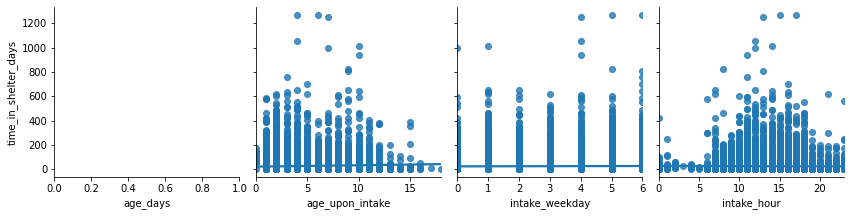

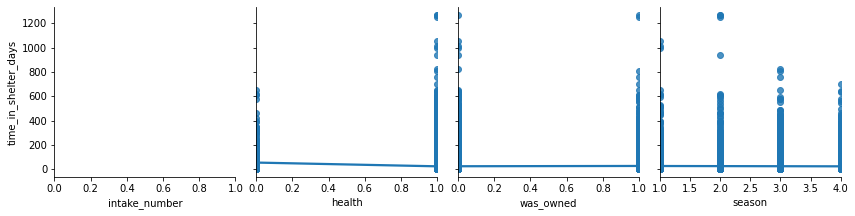

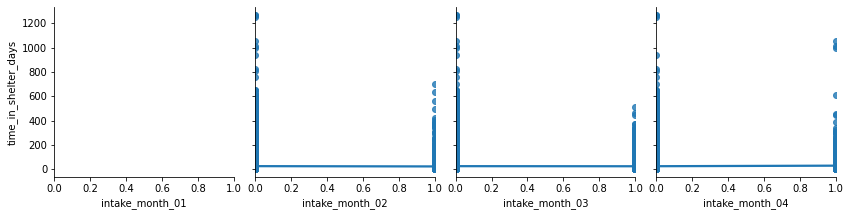

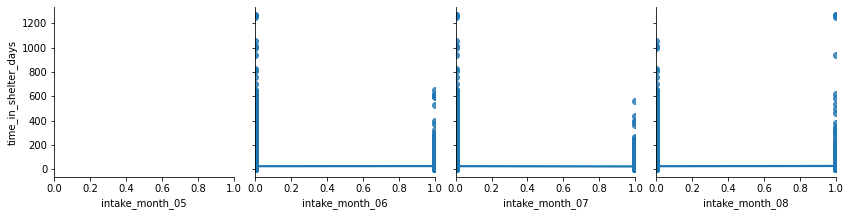

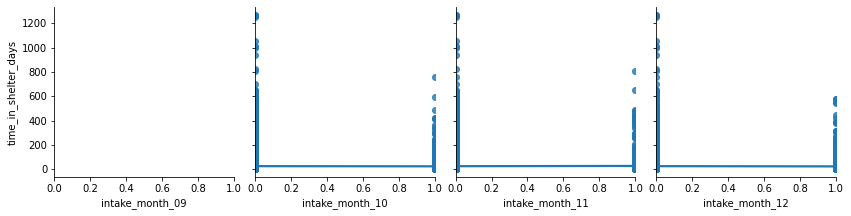

In [62]:
for i in row_groups:
    pp = sns.pairplot(data=df2, y_vars=['time_in_shelter_days'],x_vars=i, kind="reg", height=3)

(array([1.754e+04, 1.756e+03, 5.660e+02, 2.710e+02, 1.630e+02, 8.600e+01,
        4.400e+01, 3.600e+01, 2.900e+01, 2.900e+01, 1.700e+01, 8.000e+00,
        7.000e+00, 8.000e+00, 6.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([6.94444444e-04, 4.22998380e+01, 8.45989815e+01, 1.26898125e+02,
        1.69197269e+02, 2.11496412e+02, 2.53795556e+02, 2.96094699e+02,
        3.38393843e+02, 3.80692986e+02, 4.22992130e+02, 4.65291273e+02,
        5.07590417e+02, 5.49889560e+02, 5.92188704e+02, 6.34487847e+02,
        6.76786991e+02, 7.19086134e+02, 7.61385278e+02, 8.03684421e+02,
        8.45983565e+02, 8.88282708e+02, 9.30581852e+02, 9.72880995e+02,
        1.01518014e+03, 1.05747928e+03, 1.09977843e+03, 1.14207757e+03,
        1.18437671e+03, 1.22667586e+03, 1.26897500e+03]),
 <BarContainer object of 30 artists>)

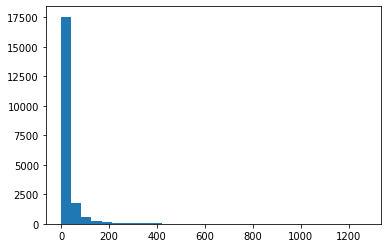

In [63]:
plt.hist(df2.time_in_shelter_days,bins=30)

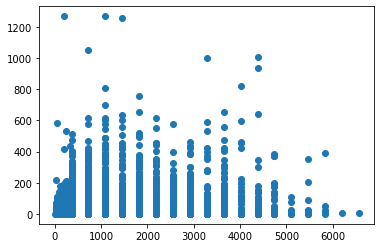

In [64]:
plt.scatter(df2.age_days, df2.time_in_shelter_days)

In [65]:
lr_model = ols(formula='time_in_shelter_days~age_days+intake_weekday+intake_hour+intake_number+health+was_owned+season+intake_month_01+intake_month_02+intake_month_03+intake_month_04+intake_month_05+intake_month_06+intake_month_07+intake_month_08+intake_month_09+intake_month_10+intake_month_11+intake_month_12', data=df2).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     time_in_shelter_days   R-squared:                       0.052
Model:                              OLS   Adj. R-squared:                  0.051
Method:                   Least Squares   F-statistic:                     63.01
Date:                  Sat, 12 Sep 2020   Prob (F-statistic):          3.27e-223
Time:                          14:54:32   Log-Likelihood:            -1.1063e+05
No. Observations:                 20581   AIC:                         2.213e+05
Df Residuals:                     20562   BIC:                         2.215e+05
Df Model:                            18                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          36.2451      3.006     12.059      0.000      30.354      42.137
age_days            0.0123      0.000     28.554      0.000       0.011       0.013
intake_weekday      0.4787      0.185      2.594      0.009       0.117       0.840
intake_hour         0.0366      0.126      0.290      0.771      -0.210       0.284
intake_number       0.8387      0.712      1.178      0.239      -0.557       2.235
health            -29.6296      1.894    -15.646      0.000     -33.342     -25.918
was_owned          -0.7271      0.856     -0.849      0.396      -2.405       0.951
season              0.9611      0.758      1.268      0.205      -0.525       2.447
intake_month_01     0.1929      1.728      0.112      0.911      -3.194       3.579
intake_month_02    -0.4922      1.745     -0.282      0.778      -3.912       2.928
intake_month_03     2.1419      1.301      1.646      0.100      -0.408       4.692
intake_month_04     8.4803      1.650      5.141      0.000       5.247      11.714
intake_month_05     6.3872      1.584      4.032      0.000       3.282       9.492
intake_month_06     4.3746      1.431      3.056      0.002       1.569       7.180
intake_month_07     1.5506      1.301      1.192      0.233      -0.999       4.100
intake_month_08     5.1903      1.280      4.054      0.000       2.681       7.700
intake_month_09     2.4275      1.300      1.867      0.062      -0.121       4.976
intake_month_10     1.3129      1.305      1.006      0.314      -1.245       3.871
intake_month_11     4.1630      1.350      3.083      0.002       1.517       6.809
intake_month_12     0.5160      1.408      0.366      0.714      -2.244       3.276
==============================================================================
Omnibus:                    27324.030   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          8680110.235
Skew:                           7.417   Prob(JB):                         0.00
Kurtosis:                     102.509   Cond. No.                     1.36e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.4e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [68]:
df2[df2.time_in_shelter<10][['intake_type','outcome_type','time_in_shelter_days']]

,intake_type,outcome_type,time_in_shelter_days
1,Public Assist,Adoption,9.020139
4,Stray,Adoption,2.755556
12,Public Assist,Adoption,6.954167
13,Stray,Adoption,5.331944
14,Owner Surrender,Adoption,2.311806
...,...,...,...
20576,Stray,Adoption,3.783333
20577,Stray,Adoption,5.039583
20578,Stray,Adoption,3.941667
20579,Stray,Adoption,5.152083
